In [1]:
import os
import glob
import json
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

In [4]:
%matplotlib notebook

In [5]:
experiment = 'gratings'
trial_epoch = 'stimulus'
responsive_test='ROC'
# --------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

In [363]:
analysis_type='by_fov' #'by_ncells' #'by_fov'
test_type=None #'ori_single' #'size_single'
class_name = 'ori'
variation_name = None
match_rfs = False
overlap_thr= None #[0, 0.25, 0.5]

if test_type is None:
    test_str = 'default'
else:
    test_str = '%s_%s' % (test_type, variation_name) \
                    if variation_name is not None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)
print(basedir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/default


In [364]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, meta=meta, 
                                    traceid=traceid,
                                    response_type=response_type, 
                                    trial_epoch=trial_epoch,
                                    responsive_test=responsive_test,
                                    responsive_thr=responsive_thr)
cells0 = aggr.get_all_responsive_cells(cells0, NDATA0)
# input data
NDATA = aggr.get_neuraldata_for_included_cells(cells0, NDATA0)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs


In [365]:
min_ncells = 10
counts_by_fov = aggr.count_n_cells(NDATA)
pass_n_cells = counts_by_fov[counts_by_fov.n_cells>=min_ncells]
too_few_cells = counts_by_fov[counts_by_fov.n_cells<min_ncells]

## Output dirs

In [366]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'decoding')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/default/dff-ROC__stimulus__noRF__C1.00
dff-ROC__stimulus__noRF__C1.00


## Load

In [367]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [368]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
print(analysis_type, test_type, class_name, variation_name)
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]

by_fov None ori None
(V1) Found 8 paths
(Lm) Found 7 paths
(Li) Found 15 paths
    checking for break-corrs
(V1) Found 7 paths
(Lm) Found 7 paths
(Li) Found 15 paths


In [369]:
## Check that we have 1 for 1:
if 'noise_corrs' in iterdf.columns:
    df_a = iterdf[iterdf.noise_corrs=='intact']['datakey'].unique()
    df_b = iterdf[iterdf.noise_corrs=='shuffled']['datakey'].unique()
    print(len(df_a), len(df_b))

29 28


In [370]:
if len(df_a) != len(df_b):
    cond_w_less = 'shuffled' if len(df_a)>len(df_b) else 'intact'
    cond_w_more = 'intact' if cond_w_less=='shuffled' else 'shuffled'
    iterdf_og = iterdf.copy()
    i_list=[]
    df_a = iterdf_og[iterdf_og.noise_corrs==cond_w_more]
    df_b = iterdf_og[iterdf_og.noise_corrs==cond_w_less]
    for (va, dk), g in df_a.groupby(['visual_area', 'datakey']):
        if not df_b[(df_b.visual_area==va) & (df_b.datakey==dk)].empty:
            i_list.append(g)
            i_list.append(df_b[(df_b.visual_area==va) & (df_b.datakey==dk)])
        else:
            print(dk)
    iterdf = pd.concat(i_list, axis=0)

20190613_JC097_fov1


In [371]:
iterdf['noise_corrs'].unique()

array(['intact', 'shuffled'], dtype=object)

In [372]:
if 'train_transform' in iterdf.columns:
    iterdf['sf'] = [round(float(i.split('_')[0]), 1) for i in iterdf['train_transform'].values]
    iterdf['size'] = [int(float(i.split('_')[1])) for i in iterdf['train_transform'].values]
    iterdf['speed'] = [int(float(i.split('_')[2])) for i in iterdf['train_transform'].values]
    iterdf['size_type'] = ['fullfield' if i==200 else 'apertured' \
                          for i in iterdf['size'].values]

#### Check if don't have 1 low and 1 high config

In [373]:
load_err_configs = True
parent_dir  = os.path.split(basedir)[0]
wrong_configs_file = os.path.join(parent_dir, 'incorrect_configs.json')
if load_err_configs:
    with open(wrong_configs_file, 'r') as f:
        err_configs = json.load(f)
else:
    err_configs = dict((k, []) for k in ['size', 'sf', 'speed'])
    if 'train_transform' in iterdf.columns:
        for param in ['size', 'sf', 'speed']:
            iterdf['%s_rel' % param] = None
        for (va, dk), g in iterdf.groupby(['visual_area','datakey']):
            for param in ['size', 'sf', 'speed']:
                if len(g[param].unique())!=2:
                    err_configs[param].append(dk)
                    continue
                minv, maxv = sorted(g[param].unique())
                iterdf.loc[g[g[param]==minv].index, '%s_rel' % param] = 'low'
                iterdf.loc[g[g[param]==maxv].index, '%s_rel' % param] = 'high'
    with open(wrong_configs_file, 'w') as f:
        json.dump(err_configs, f, indent=4)

In [374]:
wrong_configs_by_param = err_configs.values()
wrong_configs = np.unique([item for sublist in wrong_configs_by_param \
                           for item in sublist])
wrong_configs

array(['20190306_JC061_fov2', '20190314_JC070_fov1',
       '20190315_JC070_fov2', '20190319_JC067_fov1',
       '20190321_JC070_fov2', '20190511_JC083_fov1',
       '20190512_JC083_fov1', '20190522_JC089_fov1',
       '20190527_JC092_fov3'], dtype='<U19')

In [375]:
# Exclude dkeys with wrong config
iterdf_x = iterdf[~(iterdf.datakey.isin(wrong_configs))].copy()

In [376]:
mean_df0.columns

Index(['visual_area', 'condition', 'iteration', 'noise_corrs', 'fit_time',
       'score_time', 'test_score', 'train_score', 'heldout_test_score', 'C',
       'randi', 'n_cells', 'n_trials', 'intact'],
      dtype='object')

In [377]:
iterdf_x['noise_corrs'].unique()

array(['intact', 'shuffled'], dtype=object)

In [389]:
test_type

In [391]:
grouper = ['visual_area', 'condition', 'iteration']
if 'noise_corrs' in iterdf.columns:
    grouper.append('noise_corrs')
if 'train_transform' in iterdf.columns:
    grouper.extend(['sf', 'size', 'speed', 'train_transform'])
if analysis_type=='by_ncells':
    grouper.extend(['n_cells'])
mean_df0 = dec.average_within_iterations_by_ncells(iterdf_x, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 
if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby(grouper)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'novel'], columns='noise_corrs')
else:
    columns='n_cells' if analysis_type=='by_ncells' else 'noise_corrs'
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby(grouper)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index='visual_area', columns=columns)
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: gratings (class=ori): dff-ROC__stimulus__noRF__C1.00


heldout_test_score           iteration         
noise_corrs             intact  shuffled    intact shuffled
visual_area                                                
Li                    0.165330  0.158290     249.5    249.5
Lm                    0.267608  0.254717     249.5    249.5
V1                    0.283668  0.263063     249.5    249.5

In [384]:
grouper = ['visual_area', 'condition', 'iteration']
if 'train_transform' in iterdf.columns:
    grouper.extend(['sf', 'size', 'speed', 'train_transform'])
if 'noise_corrs' in iterdf.columns:
    grouper.extend(['noise_corrs'])
mean_df0 = dec.average_within_iterations_by_ncells(iterdf_x, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 

mean_df0[ (mean_df0.condition=='data')]\
            .groupby(grouper)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'noise_corrs'])

heldout_test_score  iteration
visual_area noise_corrs                               
Li          intact                 0.165330      249.5
            shuffled               0.158290      249.5
Lm          intact                 0.267608      249.5
            shuffled               0.254717      249.5
V1          intact                 0.283668      249.5
            shuffled               0.263063      249.5

# BY_NCELLS

In [385]:
max_ncells=201 if analysis_type=='by_ncells' else np.inf  # 96 if match_Rfs
special_cases = [169, 120, 46] # 169, test; 120: for match_rfs; 46: for testing overlap_thr

n_iters = iterdf[iterdf.n_cells==max_ncells]['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
               and s not in special_cases]
xlabels = [1, 32, 64, 96, 128, max_ncells]
# grouper = ['visual_area', 'condition', 'iteration']

mean_df = mean_df0[mean_df0['n_cells'].isin(sample_sizes)]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

conditions: []


In [386]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)

nan


In [387]:
mean_df.groupby(['visual_area'])['n_cells'].max()

Series([], Name: n_cells, dtype: float64)

In [111]:
%matplotlib inline
metric='heldout_test_score'

if analysis_type=='by_ncells':
    plotd = mean_df[(mean_df['n_cells']<=max_ncells) 
                   & (mean_df['size']<200) 
                  & (mean_df['sf']==0.1) & (mean_df['speed']==20)].copy()
    # plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
    #cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
    cond_styles = {'data': '', 'shuffled': (1,1)}
    fig, axn = pl.subplots(1,3, figsize=(6., 3), dpi=150, sharex=True, sharey=True)
    for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
        ai = visual_areas.index(va)
        ax=axn[ai]; ax.set_title(va);
        sns.lineplot(x='n_cells', y=metric, data=df_, ax=ax,
                style='condition', dashes=cond_styles, ci='sd', err_style='bars',
                color=area_colors[va], lw=0.5, 
                err_kws=dict(capsize=1, linewidth=0.5))
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    pl.subplots_adjust(left=0.07, right=0.8, bottom=0.25, top=0.7,
                          wspace=0.2)
    for ax in axn:
        #ax.set_yticks(np.linspace(0.4, 1, 4))
        #ax.set_ylim([0.4,1])
        ax.set_xticks(sample_sizes)
        ax.set_box_aspect(1)
        ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
    sns.despine(trim=True)

    fig.text(0.01, 0.85, '[%s] Test scores on novel vs. trained, sd over n=%i iters' \
             % (experiment, n_iters), fontsize=8)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

    figname = 'trained_v_novel_byncells__%s' % experiment
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    pl.savefig(os.path.join(FIGDIR,  '%s.svg' % figname))

    print(dst_dir, figname)

In [112]:
aggr_id

'dff-ROC__stimulus__noRF__C1.00'

# by_fov

In [153]:
iterdf['n_cells'].unique()

array([ 22,  10,   2,   4,   9,  20,  72,  50,  38,  59,  14,  35,  24,
        41, 110, 103,  60,  76,  30, 101,  18, 129,  91, 186,  98, 171,
        89])

In [210]:
drop_wrong_configs=True

print(analysis_type, test_type)
# grouper = ['visual_area', 'condition', 'datakey', 'intact']
grouper = ['visual_area', 'condition', 'datakey', 'intact']
if 'train_transform' in iterdf.columns:
    grouper.extend(['sf', 'size_type', 'speed','train_transform'])
    grouper.extend(['size_rel', 'sf_rel', 'speed_rel'])
    
iterdf_pass = iterdf[(iterdf.n_cells>min_ncells)].copy()
print("N datakeys that pass min_ncells>=%i:" % min_ncells)
print(iterdf_pass[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())

if drop_wrong_configs:
    config_str = 'drop-wrong-configs'
    iterdf_x = iterdf_pass[~(iterdf_pass['datakey'].isin(wrong_configs))]
else:
    config_str = 'okay-wrong-configs'
    iterdf_x = iterdf_pass[~(iterdf_pass.datakey.isin(wrong_configs))]
mean_df = dec.average_across_iterations_by_fov(iterdf_x,
                        analysis_type=analysis_type, test_type=test_type,
                        grouper=grouper)
print("Final N datakeys that pass:")
print(mean_df[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("intact/break_cc:", mean_df['intact'].unique())

by_fov ori_single
N datakeys that pass min_ncells>=10:
Li    11
V1     8
Lm     7
Final N datakeys that pass:
Li    9
V1    6
Lm    5
novel: [False]
conditions: ['data' 'shuffled']
intact/break_cc: [False  True]


In [211]:
print(iterdf_pass[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())

Li    11
V1     8
Lm     7


In [215]:
match_ncells=False
# ---------------------------------
all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() if match_ncells\
                else all_counts.groupby('visual_area')['n_cells'].max().max() 
min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() if match_ncells\
                else 10
print(min_ncells, max_ncells)
# Get sample sizes
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
xlabels = [1, 32, 96, max_ncells]
# filter too few/too many cells
fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                    & (mean_df['n_cells']<=max_ncells)].copy()
counts = passdf[['visual_area', 'datakey', 'n_cells']].copy().drop_duplicates()
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])
# Add some extralabels
passdf['noise_corrs'] = ['intact' if f else 'shuffled' for f in passdf['intact'].values]
finaldf['noise_corrs'] = ['intact' if f else 'shuffled' for f in finaldf['intact'].values]

print("Final N datakeys that pass (DROP REPEATS):")
print(finaldf[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())


10 186.0
Final N datakeys that pass (DROP REPEATS):
Li    6
V1    6
Lm    5


<IPython.core.display.Javascript object>


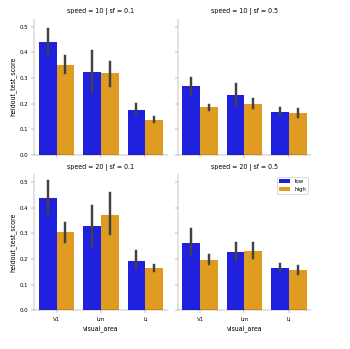

In [216]:
%matplotlib notebook
sf_colors={0.1: 'blue', 0.5: 'orange'}
size_colors={'fullfield': 'blue', 'apertured': 'orange'}
size_rel_colors={'low': 'blue', 'high': 'orange'}

df_ =finaldf[finaldf.condition=='data']
metric='heldout_test_score'
fg = sns.FacetGrid(col='sf', row='speed', data=df_, height=3)
fg.map(sns.barplot, 'visual_area', metric, 'size_rel', palette=size_rel_colors,
      order=visual_areas, hue_order=['low', 'high'])
pl.legend()
pl.subplots_adjust(bottom=0.2, right=0.8)


<IPython.core.display.Javascript object>


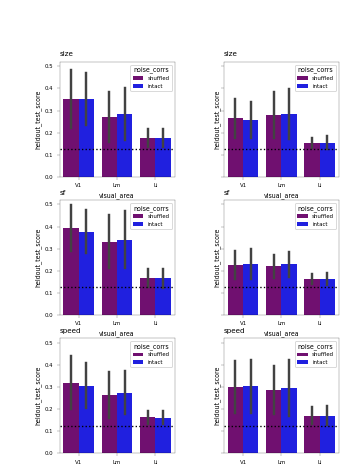

In [218]:
corr_colors={'intact': 'blue', 'shuffled': 'purple'}
df_ =finaldf[finaldf.condition=='data']

fig, axn = pl.subplots(3, 2, figsize=(6, 8), sharey=True)
for pi, param_name in enumerate(['size', 'sf', 'speed']):
    for vi, param_val in enumerate(['low', 'high']):
        ax=axn[pi, vi]
        ax.set_title(param_name, loc='left', fontsize=8)
        sns.barplot(x='visual_area', y=metric, ax=ax, 
                    data=df_[df_['%s_rel' % param_name]==param_val],
                    hue='noise_corrs', palette=corr_colors,
                    order=visual_areas, ci='sd')
for ax in axn.flat:
    ax.set_box_aspect(1)
    ax.axhline(y=chance_level, ls=':', color='k')

<IPython.core.display.Javascript object>


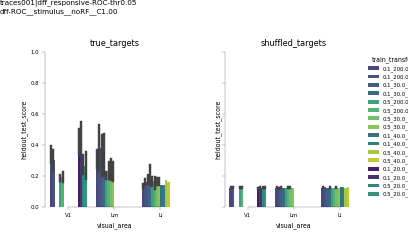

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 scores_avg_fov__dff-ROC__stimulus__noRF__C1.00


In [219]:
if test_type is not None:
    plotd0 = finaldf[(finaldf['intact'])].copy()
    plotd = plotd0.groupby(['visual_area', 'datakey','condition', 'train_transform'])\
                    .mean().reset_index()

    hue_column = 'train_transform' #if test_type is not None else 'intact'
    hue_values = sorted(plotd[hue_column].unique())
    #cond_colors = {hue_values[0]: [0.3]*3, hue_values[1]: [0.7]*3}    
    col_list = sns.color_palette('viridis', n_colors=len(hue_values))
    cond_colors = dict((k, v) for k, v in zip(hue_values, col_list))
    metric = 'heldout_test_score'

    %matplotlib notebook
    if analysis_type=='by_fov':
        fig, axn = pl.subplots(1, 2, figsize=(7,4), sharex=True, sharey=True)
        for ai, (cond, df_) in enumerate(plotd.groupby('condition')):
            title = 'true_targets' if cond=='data' else 'shuffled_targets'
            ai = 0 if cond=='data' else 1
            ax=axn[ai]; ax.set_title(title)
            sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                       hue=hue_column, palette=cond_colors, ci='sd',
                       order=visual_areas)
            ax.legend_.remove()
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=hue_column)
        pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
        ax.set_ylim([0, 1])

        sns.despine(trim=True)
        pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.3)
        figname = 'scores_avg_fov__%s' % aggr_id
        # pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
        print(dst_dir, figname)

In [222]:
hue_values

[False]

In [225]:
%matplotlib notebook
if analysis_type=='by_fov' and test_type not in [None, 'ori_single']:
    plotd0 = finaldf[(finaldf['intact'])].copy()
    plotd = plotd0.groupby(['visual_area', 'datakey','condition'])\
                    .mean().reset_index()
    hue_column = 'novel' if test_type=='' is not None else 'intact'
    hue_values = sorted(plotd[hue_column].unique())
    cond_colors = {hue_values[0]: [0.3]*3, hue_values[1]: [0.7]*3}    

    metric = 'heldout_test_score'
    fig, axn = pl.subplots(1, 2, figsize=(5.5,3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby('condition')):
        title = 'true_targets' if cond=='data' else 'shuffled_targets'
        ai = 0 if cond=='data' else 1
        ax=axn[ai]; ax.set_title(title)
        sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                   hue=hue_column, palette=cond_colors, ci='sd',
                   order=visual_areas)
        ax.legend_.remove()
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
             title=hue_column)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
    ax.set_ylim([0, 1])

    sns.despine(trim=True)
    pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.3)
    figname = 'scores_avg_fov__%s' % aggr_id
    # pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [226]:
hue_values

[True]

In [227]:
# plotd[(plotd.condition=='data') & (plotd.intact) & (plotd.visual_area=='Li')
#      & ~(plotd.novel) & (plotd.morphlevel.isin([0, 16]))]

In [228]:
too_few_cells

,visual_area,datakey,n_cells
2,Li,20190319_JC067_fov1,2
3,Li,20190321_JC070_fov2,4
4,Li,20190522_JC089_fov1,9


In [229]:
finaldf.head()

,visual_area,condition,datakey,intact,sf,size_type,speed,train_transform,size_rel,sf_rel,...,test_score,train_score,heldout_test_score,C,randi,n_trials,iteration,n_cells,size,noise_corrs
0,Li,data,20190602_JC091_fov1,False,0.1,apertured,10,0.1_30.0_10.0,low,low,...,0.213265,1.0,0.220000,1.0,4921.684,160.0,249.5,72.0,30.0,shuffled
1,Li,data,20190602_JC091_fov1,False,0.1,apertured,20,0.1_30.0_20.0,low,low,...,0.304291,1.0,0.314625,1.0,5116.186,160.0,249.5,72.0,30.0,shuffled
2,Li,data,20190602_JC091_fov1,False,0.1,fullfield,10,0.1_200.0_10.0,high,low,...,0.148650,1.0,0.157500,1.0,4946.072,160.0,249.5,72.0,200.0,shuffled
3,Li,data,20190602_JC091_fov1,False,0.1,fullfield,20,0.1_200.0_20.0,high,low,...,0.164578,1.0,0.167250,1.0,5105.470,160.0,249.5,72.0,200.0,shuffled
4,Li,data,20190602_JC091_fov1,False,0.5,apertured,10,0.5_30.0_10.0,low,high,...,0.180387,1.0,0.181562,1.0,4991.388,160.0,249.5,72.0,30.0,shuffled


In [230]:
maindf = finaldf.copy()

if test_type=='ori_single':
    paired_df = maindf[(maindf.sf==0.1)]\
                .groupby(['visual_area', 'datakey', 'noise_corrs', 
                          'condition']).mean()\
                .reset_index()
else:
    paired_df = maindf\
            .groupby(['visual_area', 'datakey', 'noise_corrs', 
                      'condition']).mean()\
            .reset_index()

In [231]:
paired_df.groupby(['visual_area', 'datakey']).count()

noise_corrs  condition  intact  sf  speed  \
visual_area datakey                                                          
Li          20190602_JC091_fov1            4          4       4   4      4   
            20190612_JC099_fov1            4          4       4   4      4   
            20190614_JC091_fov1            4          4       4   4      4   
            20190617_JC099_fov1            4          4       4   4      4   
            20191018_JC113_fov1            4          4       4   4      4   
            20191111_JC120_fov1            4          4       4   4      4   
Lm          20190513_JC078_fov1            4          4       4   4      4   
            20190525_JC084_fov1            4          4       4   4      4   
            20190603_JC080_fov1            4          4       4   4      4   
            20190618_JC097_fov1            4          4       4   4      4   
            20190627_JC091_fov1            4          4       4   4      4   
V1          20190522_JC084_fov1            4          4       4   4      4   
            20190613_JC097_fov1            4          4       4   4      4   
            20190616_JC097_fov1            4          4       4   4      4   
            20190617_JC097_fov1            4          4       4   4      4   
            20190622_JC085_fov1            4          4       4   4      4   
            20191006_JC110_fov1            4          4       4   4      4   

                                 novel  fit_time  score_time  test_score  \
visual_area datakey                                                        
Li          20190602_JC091_fov1      4         4           4           4   
            20190612_JC099_fov1      4         4           4           4   
            20190614_JC091_fov1      4         4           4           4   
            20190617_JC099_fov1      4         4           4           4   
            20191018_JC113_fov1      4         4           4           4   
            20191111_JC120_fov1      4         4           4           4   
Lm          20190513_JC078_fov1      4         4           4           4   
            20190525_JC084_fov1      4         4           4           4   
            20190603_JC080_fov1      4         4           4           4   
            20190618_JC097_fov1      4         4           4           4   
            20190627_JC091_fov1      4         4           4           4   
V1          20190522_JC084_fov1      4         4           4           4   
            20190613_JC097_fov1      4         4           4           4   
            20190616_JC097_fov1      4         4           4           4   
            20190617_JC097_fov1      4         4           4           4   
            20190622_JC085_fov1      4         4           4           4   
            20191006_JC110_fov1      4         4           4           4   

                                 train_score  heldout_test_score  C  randi  \
visual_area datakey                                                          
Li          20190602_JC091_fov1            4                   4  4      4   
            20190612_JC099_fov1            4                   4  4      4   
            20190614_JC091_fov1            4                   4  4      4   
            20190617_JC099_fov1            4                   4  4      4   
            20191018_JC113_fov1            4                   4  4      4   
            20191111_JC120_fov1            4                   4  4      4   
Lm          20190513_JC078_fov1            4                   4  4      4   
            20190525_JC084_fov1            4                   4  4      4   
            20190603_JC080_fov1            4                   4  4      4   
            20190618_JC097_fov1            4                   4  4      4   
            20190627_JC091_fov1            4                   4  4      4   
V1          20190522_JC084_fov1            4                   4  4      4   
            2

In [232]:
paired_df[paired_df.datakey=='20190616_JC097_fov1']

,visual_area,datakey,noise_corrs,condition,intact,sf,speed,novel,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,n_trials,iteration,n_cells,size
52,V1,20190616_JC097_fov1,intact,data,True,0.1,15.0,False,0.002839,0.000527,0.404476,1.0,0.430422,1.0,4974.2570,160.0,249.5,186.0,110.0
53,V1,20190616_JC097_fov1,intact,shuffled,True,0.1,15.0,False,0.002906,0.000529,0.125830,1.0,0.123687,1.0,4974.2570,160.0,249.5,186.0,110.0
54,V1,20190616_JC097_fov1,shuffled,data,False,0.1,15.0,False,0.002773,0.000542,0.441350,1.0,0.455359,1.0,5054.8255,160.0,249.5,186.0,110.0
55,V1,20190616_JC097_fov1,shuffled,shuffled,False,0.1,15.0,False,0.002795,0.000541,0.124193,1.0,0.124375,1.0,5054.8255,160.0,249.5,186.0,110.0


In [233]:
iterdf[iterdf.datakey=='20190616_JC097_fov1']['intact'].unique()

array([ True, False])

In [234]:
# rerun = ['20190306_JC061_fov2', '20190522_JC089_fov1', 
#  '20190315_JC070_fov2', '20190314_JC070_fov1']
# paired_df = meandf[~meandf.datakey.isin(rerun)]

<IPython.core.display.Javascript object>


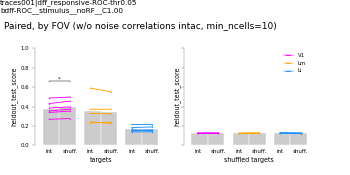

   t_stat  p_val visual_area
0     0.0  0.031          V1
   t_stat  p_val visual_area condition
0     0.0   0.03          V1      data
1     4.0   0.44          Lm      data
2     9.0   0.84          Li      data
0     9.0   0.84          V1  shuffled
1     0.0   0.06          Lm  shuffled
2     4.0   0.22          Li  shuffled
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_break_noisecorrs_heldout_test_score


In [236]:
%matplotlib notebook

metric='heldout_test_score'
if analysis_type=='by_fov':
    s_=[]
    corr_colors={'intact': 'darkblue', 'shuffled': 'lightblue'}
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(paired_df.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=1, edgecolor=['w']*3,
                         facecolor=[0.8]*3, annotate=True, sig_lw=0.5,ttest=False,
                         sig_fontsize=6, sig_height=0.01, sig_offset=None)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.round(2))

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    ax.set_xticklabels(xtick_labels)
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=visual_areas, markers='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)

fig.text(0.01, 0.85, \
    'Paired, by FOV (w/o noise correlations intac, min_ncells=%i)' % min_ncells)
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))
figname = 'paired_accuracy_break_noisecorrs_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [237]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00'

In [238]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA0['datakey'].unique(), 
                            experiment=experiment,
                            images_only=False, rename=False,
                            return_incorrect=True, return_all=False)
incorrect_stim

Checking gratings configs


{'20190314_JC070_fov1':           direction luminance  stimtype xpos ypos  ori position speed   sf  \
 config001         0      None  gratings  0.0  0.0    0   (0, 0)    10  0.1   
 config002         0      None  gratings  0.0  0.0   45   (0, 0)    10  0.1   
 config003         0      None  gratings  0.0  0.0   90   (0, 0)    10  0.1   
 config004         0      None  gratings  0.0  0.0  135   (0, 0)    10  0.1   
 config005         0      None  gratings  0.0  0.0  180   (0, 0)    10  0.1   
 config006         0      None  gratings  0.0  0.0  225   (0, 0)    10  0.1   
 config007         0      None  gratings  0.0  0.0  270   (0, 0)    10  0.1   
 config008         0      None  gratings  0.0  0.0  315   (0, 0)    10  0.1   
 
            size  
 config001  60.0  
 config002  60.0  
 config003  60.0  
 config004  60.0  
 config005  60.0  
 config006  60.0  
 config007  60.0  
 config008  60.0  ,
 '20190315_JC070_fov2':           direction luminance  stimtype  xpos ypos  ori position spe

In [239]:
metric='heldout_test_score'
df_list=[]
for (va, dk), vg in paired_df.groupby(['visual_area', 'datakey']):
    chance_ = vg[vg.condition=='shuffled'][metric].mean()
    shuff_cc = vg[(vg.condition=='data') 
                & (vg.noise_corrs=='shuffled')][metric].mean()
    intact_cc = vg[(vg.condition=='data') 
                & (vg.noise_corrs=='intact')][metric].mean()
    curr_score =float( (shuff_cc - intact_cc) / chance_)
    intact_score = float(intact_cc / chance_)
    shuff_score = float(shuff_cc / chance_)
    n_cells = int(vg['n_cells'].unique())
    
    df_ = pd.Series({'visual_area': va, 'datakey': dk, 'intact': intact_score,
                     'shuff': shuff_score, 'shuff_v_intact': curr_score,
                    'chance': chance_, 'n_cells': n_cells})
    df_list.append(df_)
scores_over_chance = pd.concat(df_list, axis=1).T
scores_over_chance['intact'] = scores_over_chance['intact'].astype(float)
scores_over_chance['shuff_v_intact'] = scores_over_chance['shuff_v_intact'].astype(float)
scores_over_chance['n_cells'] = scores_over_chance['n_cells'].astype(int)

In [240]:
df_ = scores_over_chance[~scores_over_chance.datakey.isin(incorrect_stim)]

In [241]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


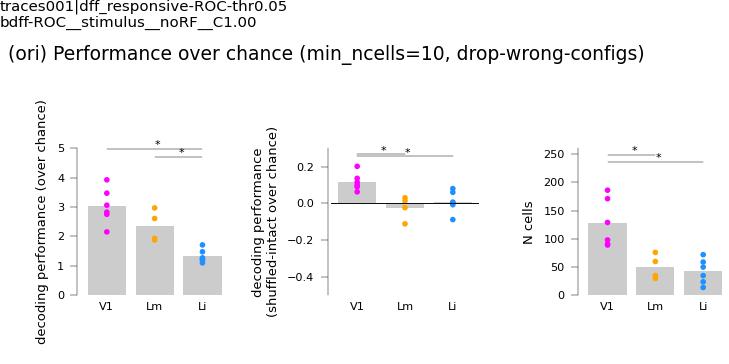

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 perf_over_chance_break_noisecorrs


In [243]:
%matplotlib notebook
stats_list = []
posthoc = 'fdr_by'
fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)
for ax, metric in zip(axn.flat, ['intact', 'shuff_v_intact', 'n_cells']):
    maxv = df_[metric].max()
    offset = maxv/15.
    ax, stats_ = pplot.stripplot_metric_by_area(df_, 
                        metric=metric, ax=ax,
                        area_colors=area_colors, posthoc=posthoc,
                        markersize=3, 
                        y_loc=maxv+(offset*3), offset=offset, ylim=None, aspect=1,
                        sig_fontsize=6, sig_lw=0.25, jitter=False,
                        return_stats=True, plot_means=True,
                        mean_style='bar', mean_type='mean')
    stats_list.append(stats_)
    if metric=='n_cells':
        ylabel = 'N cells'
    else:
        ylabel = 'decoding performance\n(shuffled-intact over chance)' \
                if metric=='shuff_v_intact' else 'decoding performance (over chance)'
    if metric=='shuff_v_intact':
        ax.set_ylim([-0.5, 0.3])
    elif metric=='intact':
        ax.set_ylim([0, 5])
    ax.set_ylabel(ylabel)
    ax.axhline(y=0, color='k', lw=0.5)
pstats = pd.concat(stats_list, axis=0)
    #ax.set
    #ax.set_ylim([-0.2, 0.3])
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.8, wspace=0.7)
fig.text(0.01, 0.85, \
    '(%s) Performance over chance (min_ncells=%i, %s)' % (class_name, min_ncells, config_str))

pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))
figname = 'perf_over_chance_break_noisecorrs'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [244]:
pstats

,Contrast,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,eta-square,metric
0,visual_area,Li,Lm,False,False,0.0,two-sided,0.014214,0.039089,fdr_by,0.654329,intact
1,visual_area,Li,V1,False,False,0.0,two-sided,0.005075,0.027912,fdr_by,0.772229,intact
2,visual_area,Lm,V1,False,False,4.0,two-sided,0.109819,0.201336,fdr_by,0.254861,intact
0,visual_area,Li,Lm,False,False,15.0,two-sided,0.594032,1.000000,fdr_by,0.064792,shuff_v_intact
1,visual_area,Li,V1,False,False,1.0,two-sided,0.008239,0.039089,fdr_by,0.502539,shuff_v_intact
2,visual_area,Lm,V1,False,False,0.0,two-sided,0.014214,0.039089,fdr_by,0.625602,shuff_v_intact
0,visual_area,Li,Lm,False,False,8.5,two-sided,0.521166,0.955471,fdr_by,0.031851,n_cells
1,visual_area,Li,V1,False,False,0.0,two-sided,0.005075,0.027912,fdr_by,0.612846,n_cells
2,visual_area,Lm,V1,False,False,0.0,two-sided,0.014214,0.039089,fdr_by,0.533241,n_cells


In [142]:
cols = ['visual_area', 'datakey', 'noise_corrs', \
                      'condition', 'train_transform', 'train_score', 'test_score', 'heldout_test_score']
# test = maindf[~(maindf.novel) & (maindf.morphlevel.isin[0, 106])] \
#             .groupby(['visual_area', 'datakey', 'noise_corrs', \
#                       'condition', 'train_transform']).mean()
# test.head()

In [180]:
datad[(datad.intact) & (datad.visual_area=='Li')]

,visual_area,datakey,noise_corrs,condition,train_transform,intact,novel,test_transform,morphlevel,fit_time,...,test_score,train_score,heldout_test_score,C,randi,p_chooseB,n_samples,n_trials,iteration,n_cells
9,Li,20190322_JC073_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001013,...,0.506302,0.993029,0.498833,1.0,5029.296,0.503667,6.000,60.0,249.5,38.0
29,Li,20190327_JC073_fov1,intact,shuffled,50.0,True,False,50.0,0,0.002611,...,0.489744,0.797771,0.504083,1.0,4872.406,0.492000,12.000,120.0,249.5,27.0
49,Li,20190422_JC076_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001030,...,0.491751,0.966576,0.491500,1.0,4898.302,0.513333,6.000,60.0,249.5,29.0
69,Li,20190602_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001110,...,0.501960,1.000000,0.493000,1.0,4998.806,0.503667,6.000,60.0,249.5,87.0
89,Li,20190606_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000988,...,0.505695,0.999912,0.510923,1.0,5018.906,0.498524,6.494,64.0,249.5,48.0
109,Li,20190607_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000937,...,0.501662,0.999979,0.488833,1.0,4928.998,0.520667,6.000,60.0,249.5,52.0
129,Li,20190609_JC099_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000896,...,0.505849,1.000000,0.509500,1.0,5008.414,0.497667,6.000,60.0,249.5,57.0
149,Li,20190612_JC099_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001109,...,0.503858,0.997853,0.516167,1.0,5010.000,0.478667,6.000,60.0,249.5,38.0
169,Li,20190614_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000956,...,0.492689,1.000000,0.485833,1.0,5056.756,0.513000,6.000,60.0,249.5,78.0
189,Li,20191018_JC113_fov1,intact,shuffled,50.0,True,False,50.0,0,0.002489,...,0.501712,0.947406,0.506261,1.0,5051.996,0.492106,11.534,114.0,249.5,47.0


In [144]:
maindf[~(maindf.novel) & (maindf.morphlevel.isin([0, 106]))][cols].drop_duplicates().shape

(840, 8)

In [145]:
840*2.

1680.0

# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:
class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


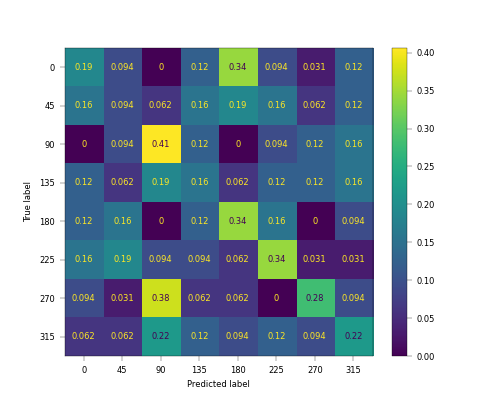

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")